# R4 on MNIST

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FullyConnected
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import mnist

## Pre-train the model

In [54]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
pretrain_batchsize = 1000
pretrain_n_epochs = 10
pretrain_learning_rate = 0.01

cuda:0


In [62]:
# define model, dataset and optimizer
model = FullyConnected(784, 10, 100, 1)
model.append(torch.nn.Softmax(dim=1))
dl_train, dl_test = mnist.get_dataloaders(pretrain_batchsize)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=pretrain_learning_rate)
model = model.to(device)
MASK_THRESHOLD = 0.05
print(model)

FullyConnected(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


In [63]:
# Extract the dataset from the dataloader
train_data_inputs, train_data_labels = dl_train.dataset.tensors[0], dl_train.dataset.tensors[1] # i.e. the first tuple element, which is the input
num_elems_train = train_data_inputs.shape[0]
# So, mark as 1 the irrelevant features
train_masks = torch.where(train_data_inputs > MASK_THRESHOLD, 0, 1).to(device)
masks_dset = torch.utils.data.TensorDataset(train_data_inputs, train_data_labels, train_masks)
dl_masks = torch.utils.data.DataLoader(masks_dset, batch_size=pretrain_batchsize, shuffle=True)

In [64]:
def visualize_gradient(batch_input, batch_labels, batch_mask, elem_idx):
    batch_input, batch_labels = batch_input.to(device).flatten(start_dim=1), batch_labels.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", 0.1, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(2, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])

Batch input shape: torch.Size([1000, 1, 28, 28]), batch mask shape: torch.Size([1000, 1, 28, 28])


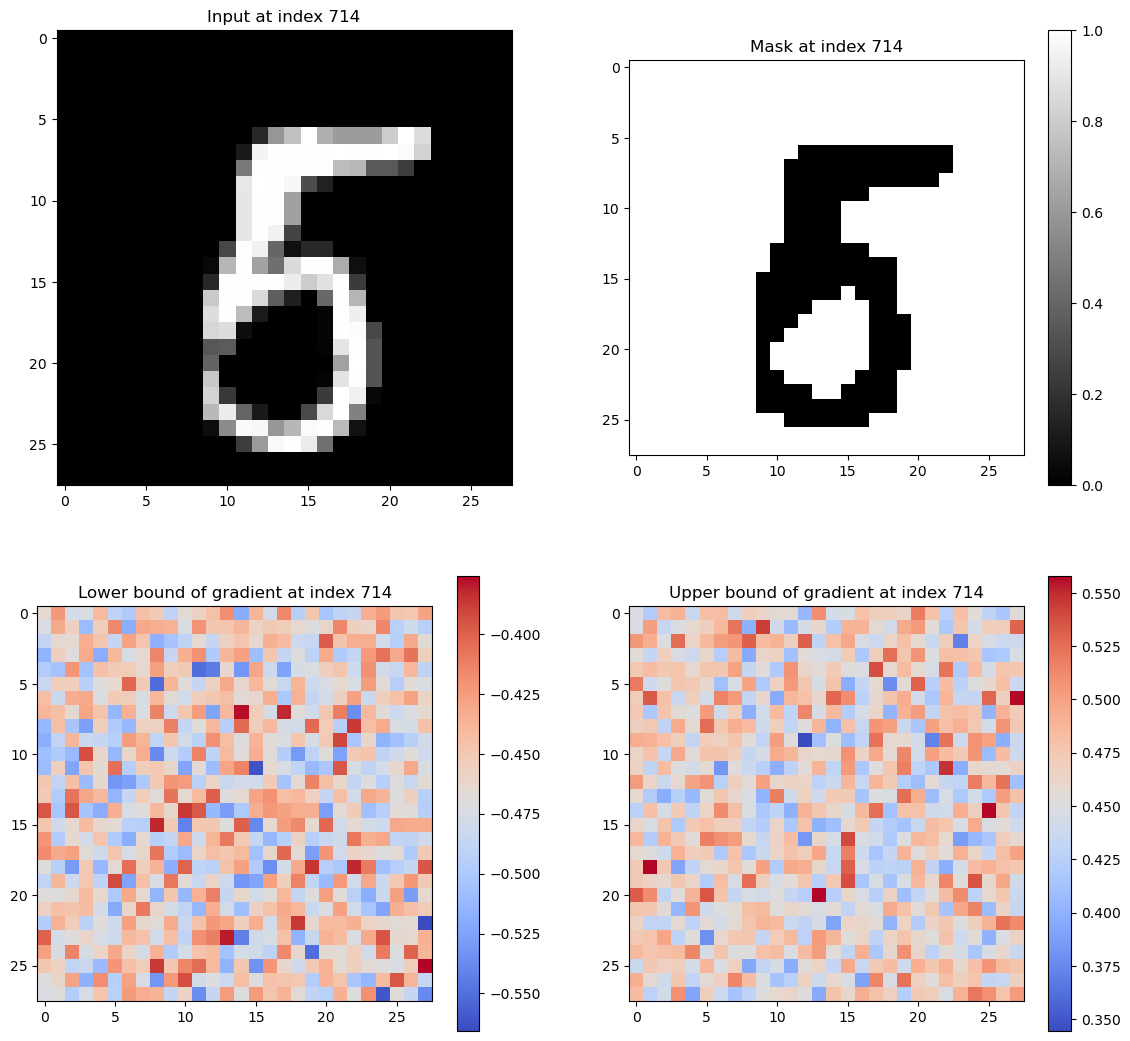

In [65]:
idx_to_visualize = torch.randint(0, pretrain_batchsize, (1,)).item()
init_batch_train_with_masks = next(iter(dl_masks))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(*init_batch_train_with_masks, idx_to_visualize)

In [66]:
# pre-train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
progress_bar = tqdm.trange(15, desc="Epoch", )
for epoch in progress_bar:
    for i, (x, u, m) in enumerate(dl_masks):
        # Forward pass
        u, x = u.to(device), x.to(device).flatten(start_dim=1)
        m = m.to(device).flatten(start_dim=1)

        output = model(x)
        y = torch.nn.functional.one_hot(u, num_classes=10).float()
        loss = criterion(output, y)
        if epoch > 1:
            inp_grad_reg = input_gradient_interval_regularizer(
                model, x, u, "cross_entropy", 0.1, 0.0, regularizer_type="r4", batch_masks=m
            )
            loss += 0.1 * inp_grad_reg
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            progress_bar.set_postfix(loss=loss.item())

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch:  40%|████      | 6/15 [00:08<00:13,  1.45s/it, loss=2.37]


KeyboardInterrupt: 

In [60]:
# evaluate the pre-trained model
# here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
param_n, param_l, param_u = ct_utils.get_parameters(model)
all_acc, i = 0, 0
for test_batch, test_labels in dl_test:
    all_acc += agt.test_metrics.test_accuracy(param_n, param_l, param_u, test_batch, test_labels, model=model)[1]
    i += 1
all_acc /= i
print("=========== Pre-trained model accuracy ===========")
print(f"All Classes      : nominal = {all_acc:.2g}")

=========== Pre-trained model accuracy ===========
All Classes      : nominal = 0.098


Batch input shape: torch.Size([1000, 1, 28, 28]), batch mask shape: torch.Size([1000, 1, 28, 28])


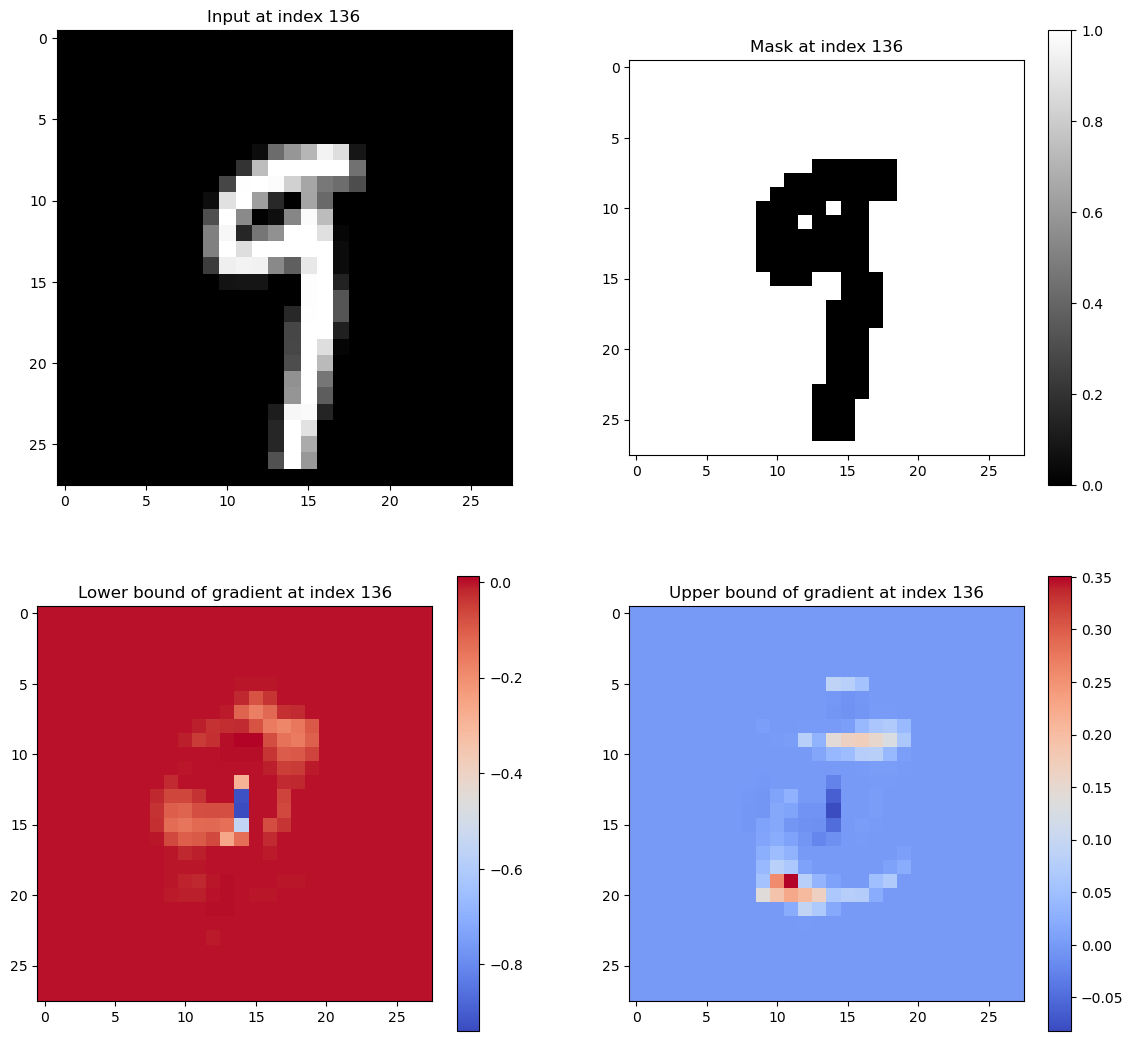

In [44]:
init_batch_train_with_masks = next(iter(dl_masks))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(*init_batch_train_with_masks, idx_to_visualize)


## Fine tune using poisoning 

In [11]:
# set up fine-tuning parameters
config = AGTConfig(
    fragsize = 200,
    learning_rate = 0.1,
    l2_reg=0.01,
    n_epochs = 1,
    k_poison=1,
    epsilon=0,
    device = "cuda:0" if torch.cuda.is_available() else "cpu",
    forward_bound = "interval",
    backward_bound = "interval",
    loss = "cross_entropy",
    lr_decay=2.0,
    lr_min=0.05,
    last_layer_activation = "softmax"
)

In [ ]:
# fine-tune the model using abstract gradient training
%reload_ext autoreload
param_l, param_n, param_u, grad_inputs, ordered_inputs, ordered_labels = agt.poison_certified_training(model, config, dl_train, dl_test, return_input_grad=True)

In [ ]:
# evaluate the fine-tuned model
test_batch, test_labels = next(iter(dl_test))
all_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, test_batch, test_labels, model=model)

print("=========== Fine-tuned model accuracy + bounds ===========")
print(f"All Classes      : nominal accuracy = {all_acc[1]:.2g}, certified lower bound = {all_acc[0]:.2g}, certified upper bound = {all_acc[2]:.2g}")

In [ ]:
print(grad_inputs[0].shape)
print(len(grad_inputs))
print(param_l[0].shape)

In [ ]:
plt.imshow(ordered_inputs[0][512].reshape(28, 28).cpu().numpy(), cmap='gray')
print(ordered_labels[0].shape)
print(ordered_labels[0][512])
print(ordered_inputs[0][512].reshape(28, 28))

In [ ]:
visualized_grad = grad_inputs[0][512]
print(visualized_grad.shape)
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
# reshape into 28x28
for i in range(5):
    for j in range(2):
        g = visualized_grad[i * 2 + j].reshape(28, 28).cpu().detach().numpy()
        ax[i, j].imshow(g, cmap='coolwarm')
        ax[i, j].title.set_text(f"Gradient for class {i * 2 + j}")